# Sediment-hosted base metals and lithospheric thickness

This minpot-toolkit example Notebook emulates the research of [Hoggard et al. (2020)](https://doi.org/10.1038/s41561-020-0593-2) and [Czarnota et al. (2021)](http://dx.doi.org/10.11636/134991) to statistically test the spatial association between cratonic edges and sediment-hosted base metal mineral systems, and then apply this relationship to infer maps of mineral prospectivity.

First, we import key modules, setup the working directory, and download the casestudy datasets.

In [ ]:
toolkit_directory = r'path_to/minpot-toolkit'
working_directory = r'.'
cartopy_directory = r'path_to/cartopy'

# If uncertain on the Cartopy installation directory, uncomment and run the following commands for a list of locations to search:
#import site
#site.getsitepackages()

In [1]:
from matplotlib import pyplot as plt
import requests
import tarfile
import os
import sys
import rasterio
from rasterio.plot import show
import pandas
import cartopy.crs as ccrs

sys.path.append(toolkit_directory)
os.chdir(working_directory)

# Make a dedicated folder for the example and step into it
example_path = 'LAB_example'
if not os.path.exists(example_path):
    os.mkdir('LAB_example')
os.chdir('LAB_example')
if not os.path.exists('outputs'):os.mkdir('outputs')
if not os.path.exists('data'):os.mkdir('data')

In [2]:
# Download example data from Hoggard et al. (2020): https://doi.org/10.1038/s41561-020-0593-2
os.chdir('data')
# Lithospheric thickness tarball
r = requests.get(r'https://static-content.springer.com/esm/art%3A10.1038%2Fs41561-020-0593-2/MediaObjects/41561_2020_593_MOESM2_ESM.gz')
with open('41561_2020_593_MOESM2_ESM.gz', 'wb') as f:
    f.write(r.content)
with tarfile.open('41561_2020_593_MOESM2_ESM.gz') as f:
    f.extractall('.')
r.close()
del r
# Deposit Excel file
r = requests.get(r'https://static-content.springer.com/esm/art%3A10.1038%2Fs41561-020-0593-2/MediaObjects/41561_2020_593_MOESM3_ESM.xls')
with open('41561_2020_593_MOESM3_ESM.xls', 'wb') as f:
    f.write(r.content)
r.close()
del r

os.chdir('..')

## Tomographic models of lithospheric thickness

To begin, update the variable $i$ to select a model of lithospheric thickness. The underlying seismic tomographic models are listed below.

In [3]:
i = 3
tomo_models = ['3D2015-07Sv', # 0 - Debayle et al.(2016)
               'AuSREM',      # 1 - Kennett et al. (2013)
               'CAM2016',     # 2 - Ho, Priestley & Debayle (2016), Priestley et al.(2018)
               'FR12',        # 3 - Fishwick & Rawlinson (2012)
               'SL2013sv',    # 4 - Schaeffer & Lebedev (2013)
               'SLNAAFSA',    # 5 - Schaeffer & Lebedev (2014), Celli et al. (2020a,b)
               'Y14']         # 6 - Yoshizawa (2014)

fp = r'data/lithospheric_thickness_maps/%s.tif' % tomo_models[i]

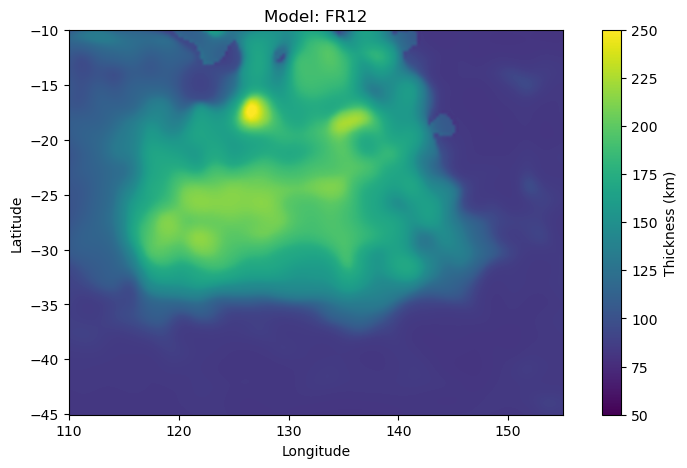

In [4]:
# Plot the selected lithospheric thickness model
fig, ax = plt.subplots(figsize=(10, 5))
img = rasterio.open(fp)
rast = show(img, ax=ax, vmin=50, vmax=250)
im   = rast.get_images()[0]
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(im, ax=ax)
plt.title('Model: %s' % tomo_models[i])
cbar.set_label('Thickness (km)')
plt.show()

## Sediment-hosted base metal deposits

Now, update the variable $j$ to select a mineral system of interest.

In [5]:
j = 0
mineral_systems = ['PbZn-CD',     # 0 - Clastic-dominated lead-zinc
                   'PbZn-MVT',    # 1 - Mississippi valley type
                   'Cu-sed',      # 2 - Sedimentary copper
                   'Magmatic Ni', # 3 - Magmatc nickel
                   'VMS',         # 4 - Volcanic massive sulphide
                   'Cu-por',      # 5 - Copper porphyry
                   'IOCG']        # 6 - Iron oxide copper gold

deposits = pandas.read_excel('data/41561_2020_593_MOESM3_ESM.xls', sheet_name='%s' % mineral_systems[j])

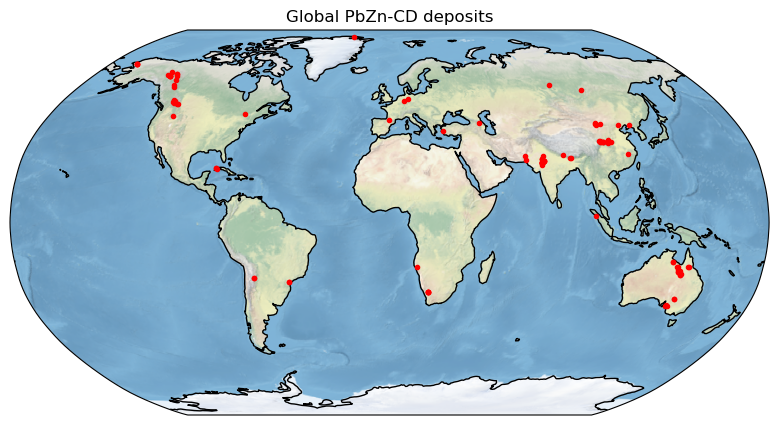

In [6]:
# Plot the deposit compilation over a global basemap
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
ax.stock_img()
ax.coastlines()

# Programmaticly handle inconsistent headers
ax.plot(deposits['Lon'+'.'*(j==0)].values,
        deposits['Lat'+'.'*(j==0)].values,
        '.',
        color='r',
        transform=ccrs.PlateCarree())

plt.title('Global %s deposits' % mineral_systems[j])

plt.show()

## Feature engineering

Here we create the XML configuration file to engineer the 170 km contour feature from the lithospheric thickness tomoographic models.

The workflow to do this is specified within an XML configuration file, which will be parsed by the minpot-toolkit. The XML file is composed of 5 key nodes:
* Commands
* Dataset
* Models
* Features
* Statistics

In [7]:
# Programmatically specify the spatial project code, if required.
if tomo_models[i] in ['3D2015-07Sv','CAM2016','SL2013sv','SLNAAFSA']:
    epsg_string = '\n            epsg="4326"'
else:
    epsg_string = ''

with open('craton_edges_feats.xml', 'w') as f:
    f.write("""<config>""")
    f.write("""
    <commands
        generate_output="True"
        bgimage=""
        model_savefile="model_savefile.npy"
        domain_savefile="domain_savefile.npy"
        data_savefile="data_savefile.npy"
        inside_polygon_file="%s/data/shapefiles/gshhs/c/GSHHS_c_L1.shp"
        input_path="./data"
        output_path="./outputs"
        make_plots="False"
        model_from_savefile="False"
        model_to_savefile="False"
        data_from_savefile="False"
        data_to_savefile="False"
        cellsize="1.0"
        read_columns="Deposit, Country, Ore (Mt)"
        point_properties="Au"
        bounds="-180, 180, -90, 90"
    />
""" % (cartopy_directory))
    # Load tomographic model into mineral-potential-toolkit
    f.write("""
    <models
        depths="0"
        depths_type="values"
        >
        <model
            name="%s"
            type="depth"
            model_format="geotiff"
            model_file_name="%s.tif"
            path="data/lithospheric_thickness_maps"%s
        />
    </models>
""" % (tomo_models[i],tomo_models[i],epsg_string))
    # Load deposit information into mineral-potential-toolkit
    # NB: Properties can be used to filter subsets from the deposit data, but here we will just use all of the data
    f.write("""
    <dataset>
        <deposits
            name="LeadZinc"
            type="PbZn-CD"
            sheet_name="PbZn-CD"
            lon_col_name="Lon%s"
            lat_col_name="Lat%s"
            file_name="data/41561_2020_593_MOESM3_ESM.xls"
            path="."
        />
        <property
            name="prop1"
            description="Country, !=, NaN"
        />
        <filter
            filters="prop1"
            condition="union"
        />
    </dataset>
""" % ('.'*(j==0), '.'*(j==0))) # Programmaticly handle inconsistent headers
    # Extract regions from the "depth" model that are out-bound from the 170km cratonic margin
    f.write("""
    <features>
        <feature name="CratonMargin" model_types="depth"
            use_existing_features="False" generate_plots="True">
            <criterion
                name="criterion1"
                model_type="depth"
                description="Value, less than, 170.0"
            />
        </feature>
    </features>
""")
    f.write("""</config>""")

The produced XML configuration file can now be run from the commandline with the following command,

```bash
python <path>/toolkit/main.py -C <path>/craton_edges_feats.xml
```

However, within this example Notebook we can run the workflow programmatically.

In [8]:
# Can be run from the commandline, but here we will call directly
from toolkit import main

ProblemManager = main.MineralPotential('craton_edges_feats.xml')
ProblemManager()

Reading models
FR12
Interpolating to grid
Finished interpolating to grid
Computing coverage region
Completed computing coverage region
Generating land polygon
Finished generating land polygon, time = 0.6525495052337646
Merging model domains
Finished merging model domains, time = 0.0010035037994384766
Computing intersection of domain with specified shapefiles
Completed computing region, time = 1.6055185794830322
Decomposing region into grid


Iteration 1 complete of 3 time = 0.26830005645751953


Iteration 2 complete of 3 time = 0.29665207862854004


Iteration 3 complete of 3 time = 1.2558729648590088
Completed generating grid, time = 1.8247904777526855
Computing union of grid squares
Completed computing union of grid squares, time = 0.676361083984375
Completed reading models, reading deposit datasets
Checking if 109 points are within coverage grid
18 points, time = 0.010209083557128906
Completed reading deposit datasets, initialising random points
Completed initialising random points
Engineering features
criterion1 depth Value less than 170.0
CratonMargin 0.023998737335205078
Completed engineering features,
Finished
Completed in 5.444970607757568 seconds.


The above workflow will save summary results to disk, but let's visualise the results.

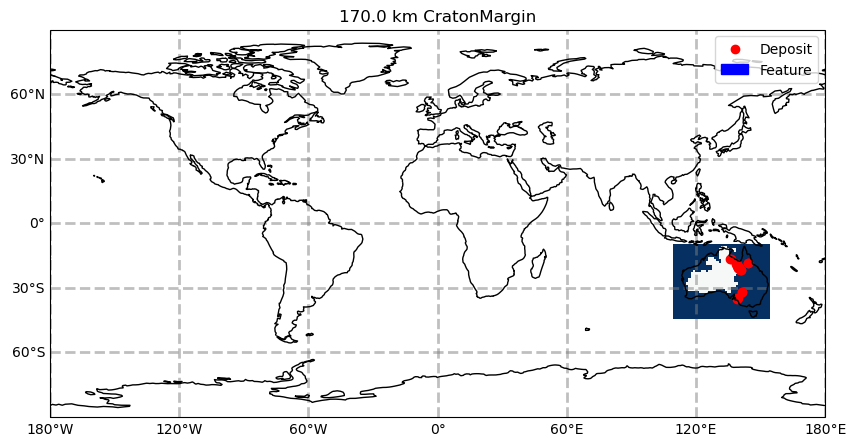

In [9]:
from toolkit.plotting import plot_feature

for key in ProblemManager.FeatureManager.feature_dict.keys():
    feat = ProblemManager.FeatureManager.feature_dict[key]
    plot_feature(feat, ProblemManager.DataManager.points_dict, 170000, "", "", False)

Here we have demonstrated the ability to engineer specific features from an input model. This enables us to translate arbitrary models into the mappable criteria that might be expected from mineral system conceptual models; i.e. converting an absolute grid of lithospheric thicknesses into a feature denoting cratonic and non-cratonic environments. The 170 km threshold used above corresponds to that adopted by Hoggard et al. (2020), however feel free to play with the XML generation above to test alternate conceptualisations (including using iterative criteria specifications within the 'features' tag).

In the following section we will investigate the spatial association of this new feature with observed mineralisation.

## Testing spatial relationships and prospectivity mapping

We have now engineered a feature that we would like to investigate for mineral potential mapping. Depending on your selections, the figure above will likely reveal a visual correlation between a sediment-hosted base metal system and lithospheric thickness. To determine the relevance of this correlation we will need to test is statistically.

Now, we amend the XML configuration file to include the 'statistics' node, providing details of the statistical tests that we would like to employ.

In [10]:
# Programmatically specify the spatial project code, if required.
if tomo_models[i] in ['3D2015-07Sv','CAM2016','SL2013sv','SLNAAFSA']:
    epsg_string = '\n        epsg="4326"\n'
else:
    epsg_string = ''

with open('craton_edges_stats.xml', 'w') as f:
    f.write("""<config>""")
    f.write("""
    <commands
        generate_output="True"
        bgimage=""
        model_savefile="model_savefile.npy"
        domain_savefile="domain_savefile.npy"
        data_savefile="data_savefile.npy"
        inside_polygon_file="%s/data/shapefiles/gshhs/c/GSHHS_c_L1.shp"
        input_path="data"
        output_path="outputs"
        make_plots="False"
        model_from_savefile="False"
        model_to_savefile="False"
        data_from_savefile="False"
        data_to_savefile="False"
        cellsize="1.0"
        read_columns="Deposit, Country, Ore (Mt)"
        point_properties="Au"
        bounds="-180, 180, -90, 90"
    />
""" % (cartopy_directory))
    # Load tomographic model into mineral-potential-toolkit
    f.write("""
    <models
        depths="0"
        depths_type="values"
        >
        <model
            name="%s"
            type="depth"
            model_format="geotiff"
            model_file_name="%s.tif"
            path="data/lithospheric_thickness_maps"%s
        />
    </models>
""" % (tomo_models[i],tomo_models[i],epsg_string))
    # Load deposit information into mineral-potential-toolkit
    # NB: Properties can be used to filter subsets from the deposit data, but here we will just use all of the data
    f.write("""
    <dataset>
        <deposits
            name="LeadZinc"
            type="PbZn-CD"
            sheet_name="PbZn-CD"
            lon_col_name="Lon%s"
            lat_col_name="Lat%s"
            file_name="data/41561_2020_593_MOESM3_ESM.xls"
            path="."
        />
        <property
            name="prop1"
            description="Country, !=, NaN"
        />
        <filter
            filters="prop1"
            condition="union"
        />
    </dataset>
""" % ('.'*(j==0), '.'*(j==0))) # Programmaticly handle inconsistent headers
    # Extract regions from the "depth" model that are out-bound from the 170km cratonic margin
    f.write("""
    <features>
        <feature name="CratonMargin" model_types="depth"
            use_existing_features="False" generate_plots="False">
            <criterion
                name="criterion1"
                model_type="depth"
                description="Value, less than, 170.0"
            />
        </feature>
    </features>
""")
    # Run statistical tests to test associations between features and deposits
    f.write("""
    <statistics>
        <statsnode
            name="test1"
            test="Kolmogorov-Smirnov p test"
            feature="CratonMargin"
            correlation="Positive"
            binsize="2000"
            n_repeats="10"
            depths_type="values"
            depths="0"
            pros_map="True"
        />
    </statistics>
""")
    f.write("""</config>""")

In [11]:
ProblemManager = main.MineralPotential('craton_edges_stats.xml')
ProblemManager()

Reading models
FR12
Interpolating to grid
Finished interpolating to grid
Computing coverage region
Completed computing coverage region
Generating land polygon
Finished generating land polygon, time = 0.6493666172027588
Merging model domains
Finished merging model domains, time = 0.008065462112426758
Computing intersection of domain with specified shapefiles
Completed computing region, time = 1.5547330379486084
Decomposing region into grid


Iteration 1 complete of 3 time = 0.26000428199768066


Iteration 2 complete of 3 time = 0.3008408546447754


Iteration 3 complete of 3 time = 1.2397522926330566
Completed generating grid, time = 1.8045926094055176
Computing union of grid squares
Completed computing union of grid squares, time = 0.7022075653076172
Completed reading models, reading deposit datasets
Checking if 109 points are within coverage grid
18 points, time = 0.0021157264709472656
Completed reading deposit datasets, initialising random points
Completed initialising random points
Engineering features
criterion1 depth Value less than 170.0
CratonMargin 0.02857041358947754
Completed engineering features,
 running analysis
Checking if 10000 points are within coverage grid
169 points, time = 0.4087550640106201
Checking if 10000 points are within coverage grid
154 points, time = 0.40417933464050293
Computing Kolmogorov-Smirnov values
Computing CDF
Completed computing CDF
Computing normed cdf
Completed computing normed cdf
Completed computing Kolmogorov-Smirnov values
Test = test1
Number of deposits = 18
Number of repeats = 10
Dep

The above workflow will save summary results to disk, but let's visualise the results. First, start with the random points that are compared to mineral deposit locations.

Checking if 10000 points are within coverage grid
149 points, time = 0.410078763961792
Checking if 10000 points are within coverage grid
150 points, time = 0.4080989360809326


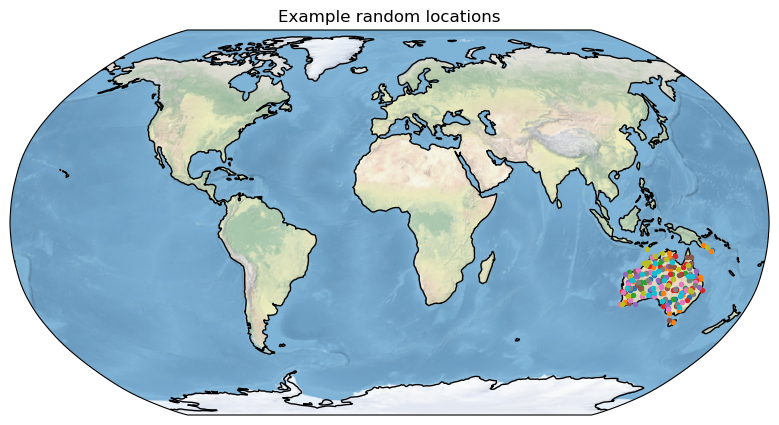

In [12]:
# Plot the random locations over a global basemap
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
ax.stock_img()
ax.coastlines()

# Currently the random locations used in analysis are not stored, but we can emulate
keys = list(ProblemManager.StatsManager.stat_obj_dict.keys())
pts_samples = ProblemManager.RPManager.seed_random_points(n_repeats=ProblemManager.StatsManager.stat_obj_dict[keys[0]].n_repeats)

# Iterate over each random locations sample
for pts in pts_samples:
    ax.plot(pts.T[0],
            pts.T[1],
            '.',
            transform=ccrs.PlateCarree())

plt.title('Example random locations')

plt.show()

Next, we can examine the cumulative frequency of the observed deposits versus the extracted, and compare relative to the multiple samples of random locations.

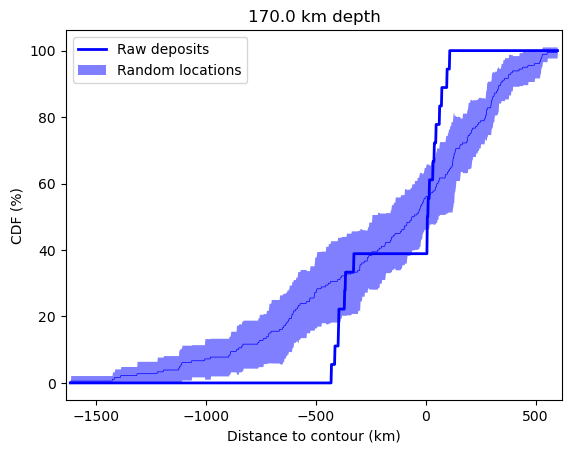

K-S statistic: 0.1027398149024942


In [13]:
from toolkit.plotting import plot_cdf_at_depth_slice

for key in ProblemManager.StatsManager.stat_obj_dict.keys():
    test = ProblemManager.StatsManager.stat_obj_dict[key]
    plot_cdf_at_depth_slice(170000, "", obj=test)
    print('K-S statistic:',test.kolmogorov_smirnov[0])

Assuming that the above relation is evaluated to be significant, it can next be used to map regions with higher probability for mineralization.

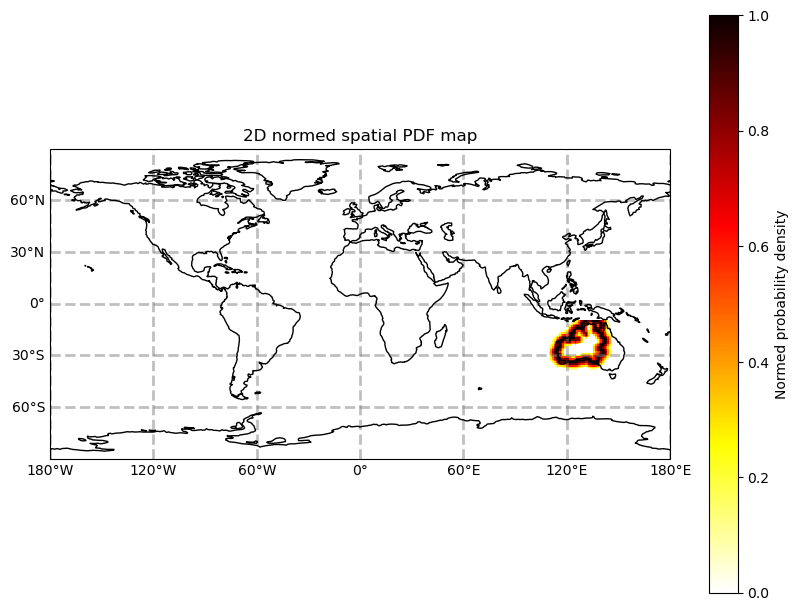

In [14]:
from toolkit.plotting import plot_pdf_map

for key in ProblemManager.Prospectivity.dct.keys():
    pros_map = ProblemManager.Prospectivity.dct[key]
    pros_map.pdf_values = pros_map.pdf(pros_map.distances)
    plot_pdf_map(obj=pros_map)